# 03 — DSSP Parsing & Structural Features (1EY0A)

This notebook:

- Parses the **DSSP** output for the model protein **1EY0 (Staphylococcal nuclease)**.
- Extracts **per-residue structural features** (secondary structure and solvent-accessible surface area, ASA).
- Maps DSSP residues to the **single-mutation ΔΔG dataset** (`single_mut_clean.csv`) for 1EY0A.
- Produces a **structurally enriched mutation table** that can later be used for improved ML models.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Resolve project root (works whether you're in project root or notebooks/)
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

PDB_ID = "1EY0"
CHAIN_ID = "A"

print("Project root:", PROJECT_ROOT)
print("Raw data:", DATA_RAW)
print("Processed data:", DATA_PROCESSED)

Project root: /Users/saturnine/protein-multimutant
Raw data: /Users/saturnine/protein-multimutant/data/raw
Processed data: /Users/saturnine/protein-multimutant/data/processed


## 1. Check DSSP Input & Output Files

We expect:

- PDB/mmCIF: `data/raw/pdb/1EY0.cif` or `1EY0.pdb`
- DSSP output: `data/raw/dssp/1EY0.dssp` (already generated using `mkdssp`)

In [2]:
pdb_dir = DATA_RAW / "pdb"
dssp_dir = DATA_RAW / "dssp"

pdb_cif = pdb_dir / f"{PDB_ID}.cif"
pdb_pdb = pdb_dir / f"{PDB_ID}.pdb"
dssp_file = dssp_dir / f"{PDB_ID}.dssp"

print("PDB CIF exists:", pdb_cif.exists(), "→", pdb_cif)
print("PDB PDB exists:", pdb_pdb.exists(), "→", pdb_pdb)
print("DSSP file exists:", dssp_file.exists(), "→", dssp_file)

# Peek at the first ~30 lines of DSSP to confirm format
if dssp_file.exists():
    with dssp_file.open() as f:
        for i, line in enumerate(f):
            if i >= 30:
                break
            print(line.rstrip())
else:
    raise FileNotFoundError("DSSP file not found. Make sure mkdssp was run correctly.")

PDB CIF exists: True → /Users/saturnine/protein-multimutant/data/raw/pdb/1EY0.cif
PDB PDB exists: True → /Users/saturnine/protein-multimutant/data/raw/pdb/1EY0.pdb
DSSP file exists: True → /Users/saturnine/protein-multimutant/data/raw/dssp/1EY0.dssp
==== Secondary Structure Definition by the program DSSP, NKI version 4.5.5                         ==== DATE=2025-11-25        .
REFERENCE M.L. HEKKELMAN ET AL, PROTEIN SCIENCE 34.8 (2025) e70208; W. KABSCH AND C.SANDER, BIOPOLYMERS 22 (1983) 2577-2637    .
HEADER    HYDROLASE                               05-MAY-00   1EY0                                                             .
COMPND    MOL_ID: 1; MOLECULE: STAPHYLOCOCCAL NUCLEASE; CHAIN: A; EC: 3.1.31.1; ENGINEERED: YES                                .
SOURCE    MOL_ID: 1; STRAIN: FOGGI; ORGANISM_SCIENTIFIC: Staphylococcus aureus; ORGANISM_TAXID: 1280; EXPRESSION_SYSTEM: Es... .
AUTHOR    J.Chen; Z.Lu; J.Sakon; W.E.Stites                                                              

## 2. DSSP Parser → Per-Residue Structural Table

DSSP output is a fixed-width text format.  
We will:

- Skip the header lines until the line starting with `"#  RESIDUE"`.
- Read each residue line and extract:
  - Chain ID
  - Residue index (PDB numbering)
  - Amino acid code
  - Secondary structure (SS)
  - Solvent accessible surface area (ASA)
- Convert blank SS (spaces) to `"C"` for coil.
- Keep only residues from **chain A** for **1EY0**.

In [3]:
def parse_dssp_to_df(dssp_path: Path, pdb_id: str, chain_filter: str = None) -> pd.DataFrame:
    """
    Parse a DSSP .dssp file into a per-residue DataFrame.

    Columns returned:
        pdb_id, chain, res_index, aa, ss, asa

    Notes:
    - res_index uses the PDB residue number (integer).
    - ss is a single-letter secondary structure code:
        H,E,G,I,B,T,S, or C for coil (blank in DSSP).
    """
    rows = []
    in_table = False

    with dssp_path.open() as f:
        for line in f:
            # Start of residue table
            if not in_table:
                if line.lstrip().startswith("#  RESIDUE"):
                    in_table = True
                continue

            # Skip empty / non-residue lines
            if not line.strip():
                continue

            # DSSP residue lines have a fixed format; use slice indices
            # Format reference: Kabsch & Sander; typical columns:
            #  1-5: DSSP index
            #  6-10: PDB residue number
            # 11: chain ID
            # 14: amino acid (AA)
            # 17: secondary structure
            # 36-38: ASA (integer)
            try:
                # Chain
                chain = line[11].strip()
                if not chain:
                    chain = "?"

                # Residue number
                resnum_str = line[5:10].strip()
                if not resnum_str or not resnum_str.lstrip("-").isdigit():
                    continue
                res_index = int(resnum_str)

                # Amino acid
                aa = line[13].strip()
                # DSSP uses special symbols for chain breaks / non-standard
                if aa in ("!", "X", "B", "*", "0"):
                    continue

                # Secondary structure
                ss_raw = line[16].strip()
                ss = ss_raw if ss_raw else "C"  # blank → coil

                # ASA (solvent-accessible surface area)
                asa_str = line[34:38].strip()
                asa = int(asa_str) if asa_str.isdigit() else np.nan

            except Exception:
                # If anything goes wrong with this line, skip it
                continue

            if chain_filter is not None and chain != chain_filter:
                continue

            rows.append(
                {
                    "pdb_id": pdb_id,
                    "chain": chain,
                    "res_index": res_index,
                    "aa": aa,
                    "ss": ss,
                    "asa": asa,
                }
            )

    dssp_df = pd.DataFrame(rows)
    # Sort by residue index for sanity
    dssp_df = dssp_df.sort_values(["pdb_id", "chain", "res_index"]).reset_index(drop=True)
    return dssp_df

## 3. Parse DSSP for 1EY0, Chain A and Save

We now:

- Parse `data/raw/dssp/1EY0.dssp`
- Filter to chain A
- Save a clean CSV under `data/processed/dssp/1EY0_A_dssp.csv`  
  (this matches the pattern expected by `attach_dssp_features()` in `feature_engineering.py`).

In [4]:
# Parse DSSP
dssp_df = parse_dssp_to_df(dssp_file, pdb_id=PDB_ID, chain_filter=CHAIN_ID)

print("Parsed DSSP rows:", len(dssp_df))
display(dssp_df.head())

# Make sure output dir exists
dssp_out_dir = DATA_PROCESSED / "dssp"
dssp_out_dir.mkdir(parents=True, exist_ok=True)

dssp_out_csv = dssp_out_dir / f"{PDB_ID}_{CHAIN_ID}_dssp.csv"
dssp_df.to_csv(dssp_out_csv, index=False)
print("Saved DSSP CSV →", dssp_out_csv)

Parsed DSSP rows: 136


,pdb_id,chain,res_index,aa,ss,asa
0,1EY0,A,6,K,C,235
1,1EY0,A,7,L,C,41
2,1EY0,A,8,H,C,111
3,1EY0,A,9,K,E,90
4,1EY0,A,10,E,E,27


Saved DSSP CSV → /Users/saturnine/protein-multimutant/data/processed/dssp/1EY0_A_dssp.csv


## 4. Merge Structural Features with Single-Mutation ΔΔG Data (1EY0A)

We now:

- Load `data/processed/single_mut_clean.csv`
- Filter to the **1EY0A** protein (matching `clid == "1EY0A"` or `pdb_id == "1EY0" & chain == "A"`).
- Merge with the DSSP table on `(pdb_id, chain, res_index)`.
- Inspect coverage (how many mutations get SS/ASA annotations).

In [5]:
# Load clean single-mutation table
clean_path = DATA_PROCESSED / "single_mut_clean.csv"
single_mut = pd.read_csv(clean_path)

print("single_mut_clean shape:", single_mut.shape)
display(single_mut.head())

# Filter to 1EY0A (use clid if available, else pdb_id/chain)
if "clid" in single_mut.columns:
    sm_1ey0a = single_mut[single_mut["clid"] == "1EY0A"].copy()
else:
    sm_1ey0a = single_mut[
        (single_mut["pdb_id"] == PDB_ID) & (single_mut["chain"] == CHAIN_ID)
    ].copy()

print("Rows for 1EY0A:", len(sm_1ey0a))
display(sm_1ey0a.head())

# Merge with DSSP: key = (pdb_id, chain, res_index)
merged = sm_1ey0a.merge(
    dssp_df,
    on=["pdb_id", "chain", "res_index"],
    how="left",
    suffixes=("", "_dssp"),
)

print("Merged shape:", merged.shape)
missing_ss = merged["ss"].isna().mean()
missing_asa = merged["asa"].isna().mean()
print(f"Missing SS fraction:  {missing_ss:.3f}")
print(f"Missing ASA fraction: {missing_asa:.3f}")

display(merged.head())

single_mut_clean shape: (2645, 9)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0


Rows for 1EY0A: 482


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C
500,1EY0A,1EY0,A,A,12.0,G,-2.37,7.0,20.0
501,1EY0A,1EY0,A,A,12.0,V,-0.89,7.0,20.0
502,1EY0A,1EY0,A,A,17.0,G,0.19,7.0,20.0
503,1EY0A,1EY0,A,A,17.0,V,-1.94,7.0,20.0
504,1EY0A,1EY0,A,A,58.0,G,-2.53,7.0,20.0


Merged shape: (482, 12)
Missing SS fraction:  0.000
Missing ASA fraction: 0.000


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,aa,ss,asa
0,1EY0A,1EY0,A,A,12.0,G,-2.37,7.0,20.0,A,E,12
1,1EY0A,1EY0,A,A,12.0,V,-0.89,7.0,20.0,A,E,12
2,1EY0A,1EY0,A,A,17.0,G,0.19,7.0,20.0,A,E,14
3,1EY0A,1EY0,A,A,17.0,V,-1.94,7.0,20.0,A,E,14
4,1EY0A,1EY0,A,A,58.0,G,-2.53,7.0,20.0,A,H,0


## 5. Quick Structural Sanity Checks

We now look at:

- Distribution of **ASA** for mutated residues.
- Counts of **secondary structure classes** (H/E/C).
- Relationship between **ΔΔG** and secondary structure (`ss`).

Rows with structural info: 482


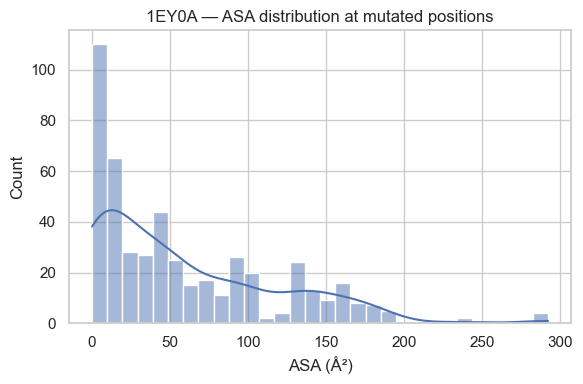

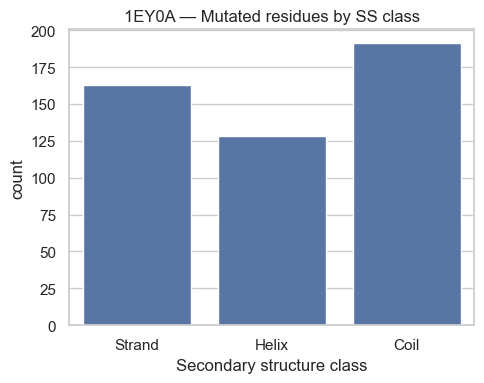

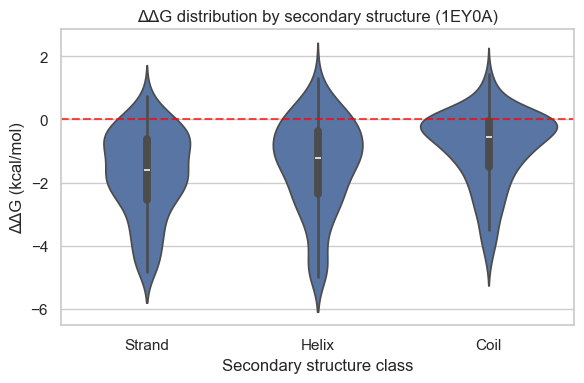

In [6]:
# Drop rows without structural annotations for plotting
merged_struct = merged.dropna(subset=["ss", "asa"]).copy()

print("Rows with structural info:", len(merged_struct))

plt.figure(figsize=(6,4))
sns.histplot(merged_struct["asa"], bins=30, kde=True)
plt.xlabel("ASA (Å²)")
plt.ylabel("Count")
plt.title("1EY0A — ASA distribution at mutated positions")
plt.tight_layout()
plt.show()

# Collapse SS into broad classes: H (helix), E (strand), C (coil/other)
def ss_coarse(s):
    if s in ("H", "G", "I"):
        return "Helix"
    if s in ("E", "B"):
        return "Strand"
    return "Coil"

merged_struct["ss_class"] = merged_struct["ss"].map(ss_coarse)

plt.figure(figsize=(5,4))
sns.countplot(data=merged_struct, x="ss_class")
plt.xlabel("Secondary structure class")
plt.title("1EY0A — Mutated residues by SS class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.violinplot(data=merged_struct, x="ss_class", y="ddg_exp_kcal", inner="box")
plt.axhline(0, ls="--", c="red", alpha=0.7)
plt.xlabel("Secondary structure class")
plt.ylabel("ΔΔG (kcal/mol)")
plt.title("ΔΔG distribution by secondary structure (1EY0A)")
plt.tight_layout()
plt.show()

## 6. Save Structurally Enriched Mutation Table

This file will be used later for:

- Improved ML models that include **ASA** and **secondary structure** as features.
- Potentially comparing performance of:
  - Sequence-only features vs.
  - Sequence + structural features.

In [7]:
out_struct = DATA_PROCESSED / "single_mut_1EY0A_struct.csv"
merged.to_csv(out_struct, index=False)
print("Saved structurally enriched mutations →", out_struct)

Saved structurally enriched mutations → /Users/saturnine/protein-multimutant/data/processed/single_mut_1EY0A_struct.csv


## 7. Next Steps (for the ML model)

In the next notebook, we can:

1. Extend `src/feature_engineering.py` to automatically merge DSSP features for any protein with `{pdb_id}_{chain}_dssp.csv` under `data/processed/dssp/`.
2. Rebuild the feature table (e.g., `features_basic_struct.csv`) combining:
   - Existing sequence/biophysical deltas (Δhydropathy, Δvolume, etc.)
   - Structural features: `ss`, `asa`, `ss_class` or one-hot SS.
3. Retrain the regression model and compare:
   - Sequence-only features vs.
   - Sequence + structure features, using:
     - R², RMSE on test set
     - Grouped CV by protein (if extended later to multiple proteins).

This notebook has successfully wired **DSSP → structural features → mutation table** for 1EY0A.  
We are now ready to plug these into improved ML models.